# LeNet CNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as ops
import time

In [2]:
print(tf.__version__)

1.13.0-rc2


## Reading Data

We are reading MNIST data from http://yann.lecun.com/exdb/mnist/


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../mnist", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../mnist/t10k-images-idx3-ubyte.gz
Extracting ../mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
print(mnist.train.num_examples) # Number of training data
print(mnist.test.num_examples) # Number of test data

55000
10000


In [5]:
batch_x, batch_y = mnist.train.next_batch(512)

In [6]:
batch_x.shape

(512, 784)

In [7]:
batch_y.shape

(512, 10)

## Setting hyper-parameters

In [8]:
# architecture hyper-parameter
noofdatapoints = mnist.train.num_examples

learningrate = 0.001
nepochs = 10
batch_size = 512
noofbatches = 10#noofdatapoints//batch_size
print("no of batches =", noofbatches)

n_input = 784 # 28x28 image
n_classes = 10 # 1 for each digit [0-9]
dropout = 0.75 

no of batches = 10


## Defining x and y as placeholders

In [9]:
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)
print(X.shape, Y.shape)

(?, 784) (?, 10)


## Defining model using conv2d, Relu and Maxpooling

In [10]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [11]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [12]:
def conv_net(x, weights, biases, dropout):
    # reshape input to 28x28 size
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max pooling
    conv1 = maxpool2d(conv1, k=2)

    # Convolution layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max pooling
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

## Initializing Weights and Biases

In [13]:
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

Instructions for updating:
Colocations handled automatically by placer.


## Define cost, optimizer and accuracy

In [14]:
# Create the model
model = conv_net(X, weights, biases, keep_prob)
print(model)
# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y))
train_min = tf.train.AdamOptimizer(learning_rate=learningrate).minimize(loss)

# Evaluate model
correct_model = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_model, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("Add_1:0", shape=(?, 10), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Running the session 
This will run the graph and use all the tensors that were previously defined

In [15]:
# Set tf saver
saver = tf.train.Saver()

model_save_dir = 'model/mnist_lenet'
if not ops.exists(model_save_dir):
    os.makedirs(model_save_dir)
train_start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
model_name = 'mnist_lenet_{:s}.ckpt'.format(str(train_start_time))
model_save_path = ops.join(model_save_dir, model_name)

In [16]:
tf.summary.scalar('accuracy', accuracy)
tf.summary.histogram('weight_1',weights['wc1'])
tf.summary.histogram('weight_2',weights['wc2'])
tf.summary.histogram('weight_3',weights['wd1'])
tf.summary.scalar('loss', loss)
        
merged_summary_op = tf.summary.merge_all()
train_start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
tf_summary_file_name = '{:s}_mnist'.format(str(train_start_time))
writer = tf.summary.FileWriter(tf_summary_file_name, tf.get_default_graph())

In [17]:
history = []

In [18]:
with tf.Session() as sess:
    sess.run(init)
    
    # Before training
    accuracycalc = sess.run(accuracy, 
                            feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1.0})
    print("Testing accuracy: %0.4f"%(accuracycalc))

    for epoch in range(nepochs):
        for _ in range(noofbatches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            #batch_y = batch_y.astype(np.float32)
            # Use training data for optimization
            sess.run(train_min, feed_dict={X:batch_x, Y:batch_y, keep_prob: dropout})
        # Validate after every epoch
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        losscalc, accuracycalc, merged_summary = \
            sess.run([loss, accuracy, merged_summary_op], feed_dict={X:batch_x, Y:batch_y, keep_prob: 1.0})
        # add tf summary
        writer.add_summary(merged_summary, epoch)

        print("Epoch: %d, Loss: %0.4f, Accuracy: %0.4f"%(epoch, losscalc, accuracycalc))
        history.append([losscalc, accuracycalc])        
    history = np.array(history)

    # When the training is complete and you are happy with the result
    accuracycalc = sess.run(accuracy, 
                            feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1.0})
    print("Testing accuracy: %0.4f"%(accuracycalc))
    
    save_path = saver.save(sess=sess, save_path=model_save_path)
    print("Model saved in path: %s" % save_path)

Testing accuracy: 0.1253
Epoch: 0, Loss: 22466.0742, Accuracy: 0.3281
Epoch: 1, Loss: 9268.9814, Accuracy: 0.6367
Epoch: 2, Loss: 5034.5410, Accuracy: 0.7676
Epoch: 3, Loss: 3864.2505, Accuracy: 0.8125
Epoch: 4, Loss: 4590.5449, Accuracy: 0.8047
Epoch: 5, Loss: 3434.3489, Accuracy: 0.8496
Epoch: 6, Loss: 3288.0845, Accuracy: 0.8457
Epoch: 7, Loss: 2835.7957, Accuracy: 0.8848
Epoch: 8, Loss: 3209.1992, Accuracy: 0.8809
Epoch: 9, Loss: 2909.9929, Accuracy: 0.8848
Testing accuracy: 0.9033
Model saved in path: model/mnist_lenet/mnist_lenet_2019-03-18-17-18-17.ckpt


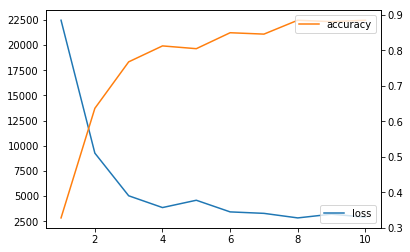

In [19]:
cmap = plt.get_cmap("tab10")

fig, ax1 = plt.subplots(facecolor='w')
ax1.plot(np.arange(1, history.shape[0] + 1), history[:, 0], label='loss')
ax2 = ax1.twinx()
ax2.plot(np.arange(1, history.shape[0] + 1), history[:, 1], label='accuracy', color=cmap(1))
ax1.legend(loc="lower right")
ax2.legend(loc="upper right")

plt.show()